In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import networkx as nx
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
import scipy as sp
from warnings import warn

### `rescomp` tests

In [2]:
from rescomp import *
from copy import deepcopy

In [3]:
from scipy.linalg import lu_factor, lu_solve

### Undriven

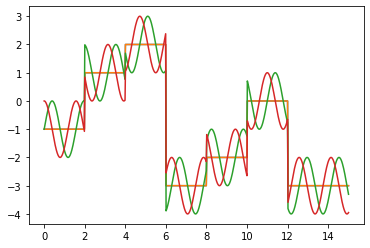

In [17]:
t  = np.linspace(0,15, 750)
steps = [-1] * 100 + [1] * 100 + [2] * 100 + [-3] * 100 + [-2] * 100 + [0] * 100 + [-3] * 150
spl = CubicSpline(t, np.array([steps, steps]).T)
drive = lambda x: spl(x).T
signal = lambda x: np.array([np.sin(4 * x), np.cos(4 * x)]) + drive(x)
plt.plot(t, drive(t).T)
plt.plot(t, signal(t).T)

In [121]:
def make_test_data():
    tr = np.linspace(0,10, 500)
    ts = np.linspace(10,15, 250)
    drive = lambda x: np.array([np.sin(x), np.cos(x)]).T
    signal = lambda x: np.array([np.cos(x), -1 * np.sin(x)]).T
    return tr, ts, drive, signal

def make_drive_data():
    t  = np.linspace(0,15, 750)
    tr = t[:450]
    ts = t[450:]
    steps = [-5] * 100 + [5] * 100 + [10] * 100 + [-15] * 100 + [-10] * 100 + [0] * 100 + [-15] * 100 + [5] * 50
    spl = CubicSpline(t, np.array([steps, steps]).T)
    drive = lambda x: spl(x).T
    signal = lambda x: np.array([np.sin(4 * x), np.cos(4 * x)]) + drive(x)
    return tr, ts, drive, signal

24.77011234420807


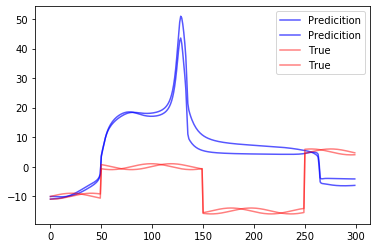

In [126]:
model = BatchResComp
ps = {**RES, **BATCH}
ps["res_sz"] = 500
ps["ridge_alpha"] = .05
tr, ts, drive, signal = make_drive_data()
rc = model(**ps)
rc.fit_batch(tr, signal, 3, overlap=.95)
pre = rc.predict(ts, u_0=signal(ts[0]))
error = np.mean(np.linalg.norm(pre - signal(ts), ord=2, axis=0)**2)**(1/2)
print(error)
plt.plot(pre.T, c='b', alpha=.66, label="Predicition")
plt.plot(signal(ts).T, c='r', alpha=.5, label="True")
plt.legend()
plt.show()

35.589970891833495


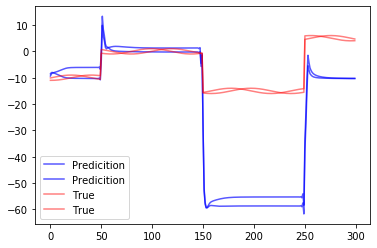

In [150]:
model = BatchDrivenResComp
ps = {**RES, **BATCH, **DRIVEN}
ps["delta"] = 2.
ps["res_sz"] = 500
ps["ridge_alpha"] = .1
ps["sigma"] = 2.0

tr, ts, drive, signal = make_drive_data()
rc = model(**ps)
rc.fit_batch(tr, signal, drive, 3, overlap=.95)
pre = rc.predict(ts, drive, u_0=signal(ts[0]))
error = np.mean(np.linalg.norm(pre - signal(ts), ord=2, axis=0)**2)**(1/2)
print(error)
plt.plot(pre.T, c='b', alpha=.66, label="Predicition")
plt.plot(signal(ts).T, c='r', alpha=.5, label="True")
plt.legend()
plt.show()

0.014025854295055623


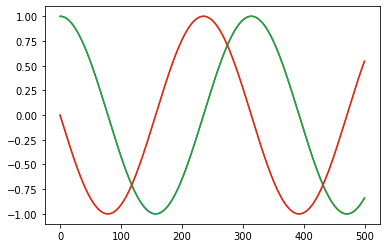

In [113]:
model = BatchResComp
ps = {**RES, **BATCH}
tr, ts, drive, signal = make_test_data()
rc = model(**ps)
rc.fit(tr, signal, inv_free=True)
pre, states = rc.predict(tr, u_0=signal(tr[0]), inv_free=True, return_states=True)
error = np.mean(np.linalg.norm(pre.T - signal(tr), ord=2, axis=0)**2)**(1/2)
print(error)
plt.plot(pre.T)
plt.plot(signal(tr))
plt.show()

In [10]:
pre = rc.Ybar @ lu_solve(rc.W_out_factors, states)

In [47]:
errs = errs.split(" ")[1:]
rc = [float(errs[i * 4].split("\n")[0]) for i in range(100)]
drc = [float(errs[i * 4 + 1].split("\n")[0]) for i in range(100)]
brc = [float(errs[i * 4 + 2].split("\n")[0]) for i in range(100)]
bdrc = [float(errs[i * 4 + 3].split("\n")[0]) for i in range(100)]


In [48]:
print(np.mean(rc))
print(np.mean(drc))
print(np.mean(brc))
print(np.mean(bdrc))

0.009916721920665774
0.009782822869169006
0.0100833848702681
0.010182427695997335


In [12]:
def _partition(t, time_window, overlap=0.0):
    """ Partition `t` into subarrays that each include `time_window` seconds. The variable
        `overlap` determines what percent of each sub-array overlaps the previous sub-array.
        The last subarray may not contain a full time window.
    """
    if (overlap >= 1) or (overlap < 0.0):
        raise ValueError("Overlap argument must be greater than or equal to zero and less than one")

    ts = ()
    start = 0
    tmax = t[start] + time_window
    for i,time in enumerate(t):
        while time > tmax:
            end = i
            if end - start == 1:
                warn(""" rescomp.ResComp._partition partitioning time array into single entry arrays. 
                         Consider increasing time window 
                     """
                    )
            ts += (t[start:end],)
            diff = floor((end - start) * (1.0 - overlap))
            start += max(diff, 1)
            tmax = t[start] + time_window
    ts += (t[start:],)
    return ts

In [99]:
for n in [100, 1000, 10000]:
    print([random_time_array(n)[-1]/n for i in range(5)])


[0.4446863184274752, 0.48995938912123, 0.45924880317910827, 0.49055912714922323, 0.5109312918568295]
[0.4919880223605753, 0.49897677454859674, 0.5079052099101581, 0.49268324523225715, 0.49538205252830014]
[0.5019345736626639, 0.5049186904369422, 0.4997679711389828, 0.5007326696180602, 0.49709188583696096]


In [5]:
def random_time_array(n, start=0):
    t = [start]
    def nextsample(t):
        t[0] += np.random.rand()
        return t[0]
    return [nextsample(t) for i in range(n)]

def uniform_time_array(n, start=0, end=500):
    return np.linspace(start, end, n)


def test_window():
    """ Make sure each partition is smaller than the given time window """
    rc = ResComp(**RES)
    for window in [.5, 3, 1001]:
        for timef in [random_time_array, uniform_time_array]:
            times = timef(1000)
            ts = rc._partition(times, window, 0)
            for sub in ts:
                assert sub[-1] - sub[0] <= window + 1e-12

def test_overlap():
    """ Ensure that overlap is correct on average """
    rc = ResComp(**RES)
    for window in [30, 100]:
        for overlap in [.1, .9,]:
            for timef in [random_time_array, uniform_time_array]:
                times = timef(1000)
                ts = rc._partition(times, window, overlap)
                prev = None
                over = 0.0
                for sub in ts:
                    if prev is not None:
                        inters = set(sub).intersection(set(prev))
                        over += len(inters) / len(sub)
                    prev = sub
                print(over/len(ts))
                assert np.abs(over/len(ts) - overlap) < .05


test_window()
test_overlap()

0.10348222769090058
0.10075187969924813
0.9022129440860397
0.9118165784832442
0.11013526492078203
0.10000000000000002
0.882903842954633
0.8863425235966225


/Users/djpassey/Code/ReservoirSpecialization/rescomp/ResComp.py:373: UserWarning: rescomp.ResComp._partition partitioning time array into                     single entry arrays. Consider increasing time window
  single entry arrays. Consider increasing time window"


In [4]:
    
# Batch and Driven Reservoir Computers

LORENZ = {
    "x0": [-20, 10, -.5],
    "begin": 0,
    "end": 60,
    "timesteps":60000,
    "train_per": .66,
    "solver": lorenz_equ
}

RES = {
    "res_sz": 50, 
    "activ_f": np.tanh,  
    "connect_p": .12,
    "ridge_alpha": .0001,
    "spect_rad": 0.5,
    "gamma": 5.,
    "sigma": 1.5,
    "uniform_weights": True,
    "solver": "ridge",
    "sparse_res": True,
    "signal_dim": 2
}

DRIVEN = {
    "delta": 0.01,
    "drive_dim": 2
}


BATCH = {
    "batchsize": 21,
}

# # Test initialization
    
def init_correct(model, params):
    rc = model(**params)
    for k in params.keys():
        msg = f"Key {k} evaluates differently in {model}, ({rc.__dict__[k]}) and params ({params[k]})"
        if k in ["connect_p", "spect_rad"]:
            assert np.abs(rc.__dict__[k] - params[k]) <= .01
        else:
            assert rc.__dict__[k] == params[k], msg
    return True
    
def test_each_model(f):
    assert f(ResComp, RES)
    assert f(DrivenResComp, {**DRIVEN, **RES})
    assert f(BatchResComp, {**BATCH, **RES})
    assert f(BatchDrivenResComp, {**BATCH, **DRIVEN, **RES})
    
# # Test driving
def make_test_data():
    tr = np.linspace(0,10, 500)
    ts = np.linspace(10,15, 250)
    drive = lambda x: np.array([np.sin(x), np.cos(x)]).T
    signal = lambda x: np.array([np.cos(x), -1 * np.sin(x)]).T
    return tr, ts, drive, signal


def drive_correct(model, ps):
    driven = model in [DrivenResComp, BatchDrivenResComp]
    tr, ts, drive, signal = make_test_data()
    rc = model(**ps)
    if driven:
        out = rc.drive(tr, drive, signal)
    else:
        out = rc.drive(tr, signal)
    if out is not None:
        m, n = out.shape
        return m == len(tr) and n == rc.res_sz
    else:
        return not np.all(rc.Hbar == 0)
    
def test_batch_size_too_big():
    ps = {**RES, "batchsize": 255}
    assert drive_correct(BatchResComp, ps)
    assert drive_correct(BatchDrivenResComp, {**ps, **DRIVEN})

# # Test fitting
def fit_correct(model, ps):
    driven = not model in [ResComp, BatchResComp]
    rc = model(**ps)
    tr, ts, drive, signal = make_test_data()
    u = lambda x: signal(x).T # Signal or transposed signal should work
    if driven:
        err = rc.fit(tr, signal, drive)
        err = rc.fit(tr, u, drive)
    else:
        err = rc.fit(tr, signal)
        err = rc.fit(tr, u)
    return True

def predict_correct(model, ps):
    driven = not model in [ResComp, BatchResComp]
    rc = model(**ps)
    tr, ts, drive, signal = make_test_data()
    rc.state_0 = rc.W_in @ signal(tr[0])
    if driven:
        err = rc.fit(tr, signal, drive)
        pre = rc.predict(tr, drive, u_0=signal(tr[0]))
    else:
        err = rc.fit(tr, signal)
        pre = rc.predict(tr, u_0=signal(tr[0]))
    error = np.mean(np.linalg.norm(pre.T - signal(tr), ord=2, axis=0)**2)**(1/2)
    if error < 1.0:
        return True
    return False

# # Test inverse free
def inv_free_correct():
    models = [BatchResComp, BatchDrivenResComp]
    params = [{**RES, **BATCH}, {**RES, **BATCH, **DRIVEN}]
    tr, ts, drive, signal = make_test_data()
    for model, ps in zip(models, params):
        rc = model(**ps)
        if model == BatchResComp:
            rc.fit(tr, signal, inv_free=True)
            pre = rc.predict(tr, u_0=signal(tr[0]), inv_free=True)
        else:
            rc.fit(tr, signal, drive, inv_free=True)
            pre = rc.predict(tr, drive, u_0=signal(tr[0]), inv_free=True)
        assert not np.all(rc.Hbar == 0)
        assert not np.all(rc.Ybar == 0)
        error = np.mean(np.linalg.norm(pre.T - signal(tr), ord=2, axis=0)**2)**(1/2)
        assert error < 1.0
    
test_each_model(init_correct)
test_each_model(drive_correct)
test_batch_size_too_big()
test_each_model(fit_correct)
test_each_model(predict_correct)
inv_free_correct()


# # Test partition

# # Test time window

# # Test overlap

# # Test exceptions for untrained and factorless inverse free 

# # Test all initial conditions

### Inverse Computation

In [14]:
n = 3000
H = np.random.randn(n, n)
%timeit Hinv = np.linalg.inv(H)
%timeit LU = sp.linalg.lu_factor(H)

617 ms ± 5.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
197 ms ± 7.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
from rescomp import *
def random_lorenz_x0():
    """ Random initial condition for lorenz equations """
    return  20*(2*np.random.rand(3) - 1)

def lorenz_dt(X, t0):
    X = tuple(x for x in X)
    return np.array(lorenz_deriv(t0, X))

x0 = random_lorenz_x0()
tr, ts, u = lorenz_equ(x0, begin=0, end=60, timesteps=60000, train_per=.66)
x0 = u(tr).T[-1, :].flatten()
v = integrate.odeint(lorenz_dt, x0, ts).T

In [28]:
u(tr).shape

(3, 39600)

In [32]:
l = list(range(1, 14))
print(l)
print(len(l))
rng = list(range(0, len(l), 3))
print(rng)
[l[i:i+3] for i in rng]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
13
[0, 3, 6, 9, 12]


[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13]]

In [34]:
np.array(l)[12:15]

array([13])

In [3]:
from math import floor
from scipy import integrate
import numpy as np

def lorentz_deriv(t0, X, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorenz system."""
    (x, y, z) = X
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
# end

def lorenz_equ(x0=[-25, -5, 10.5], begin=0, end=60, timesteps=60000, train_per=.66, clip=0):
    """Use solve_ivp to produce a solution to the lorenz equations"""
    t = np.linspace(begin,end,timesteps)
    clipped_start = floor(timesteps * clip / (end - begin))
    n_train = floor(clipped_start + train_per * (end - clip) / (end - begin) * timesteps)
    train_t = t[clipped_start:n_train]
    test_t = t[n_train:]
    u = integrate.solve_ivp(lorentz_deriv, (begin,end), x0, dense_output=True).sol
    return train_t, test_t, u

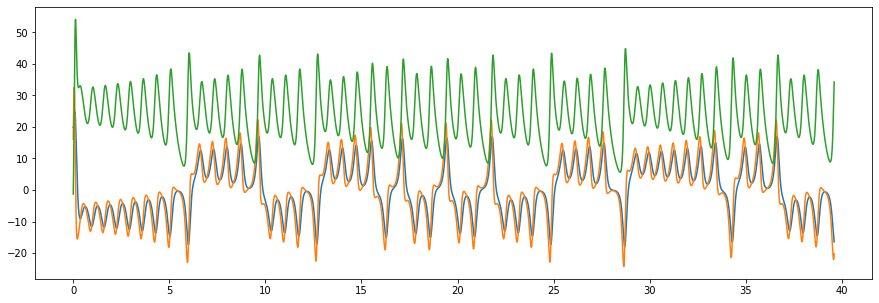

In [16]:
x0 = 40*np.random.rand(3) - 20
tr, ts, u = lorenz_equ(x0)
plt.plot(tr, u(tr).T)
plt.show()

In [17]:
plt.rcParams['figure.figsize'] = [15,5]

[-16.45350784 -20.21246349  34.25853129]


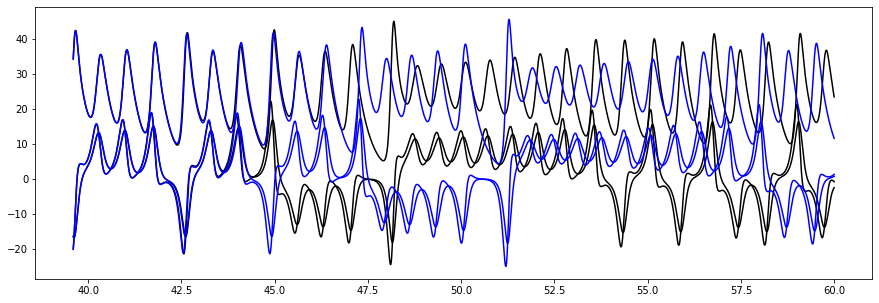

In [18]:
x0 = u(tr).T[-1, :].flatten()
print(x0)
pickup = integrate.solve_ivp(lorentz_deriv, (ts[0],ts[-1]), x0, dense_output=True).sol
plt.plot(ts, u(ts).T, c='k')
plt.plot(ts, pickup(ts).T, c='b')
plt.show()

In [ ]:
# Rolling integration

i = 0
x0 = u(ts)[:, 0].flatten()
while 


In [154]:
data = pickle.load(open("/Users/djpassey/Downloads/compiled_output_dj10_watts4.pkl", "rb"))
df = pd.DataFrame(data)

In [174]:
data = pickle.load(open("/Users/djpassey/Downloads/compiled_output_dj10_watts4.pkl", "rb"))
df = pd.DataFrame(data)
remove = df.groupby("remove_p")
remove.describe()

mean_pred                                                            \
             count         mean          std   min      25%     50%      75%   
remove_p                                                                       
0.00        1225.0  1090.897143  1314.476976   0.0     0.00   580.0  1729.00   
0.10        1189.0  1541.993272  1783.111118   0.0    47.00   635.0  3160.00   
0.96        1200.0  2405.953333  1595.441207  21.0   936.25  2207.5  3780.00   
0.98        1200.0  2750.996667  1645.843492  25.0  1137.75  2936.5  4301.25   
0.99        1200.0  2543.540000  1646.856439  81.0   958.50  2353.0  4078.50   

                 mean_err            ... ridge_alpha           exp_num  \
             max    count      mean  ...         75%       max   count   
remove_p                             ...                                 
0.00      4995.0   1225.0  4.804794  ...    0.000001  0.000001  1225.0   
0.10      4995.0   1189.0  2.716431  ...    0.000001  0.000001  1200.0   
0.96      4995.0   1200.0  0.010965  ...    0.000001  0.000001  1200.0   
0.98      4995.0   1200.0  0.012207  ...    0.000001  0.000001  1200.0   
0.99      4995.0   1200.0  0.012655  ...    0.000001  0.000001  1200.0   

                                                                   
                mean        std  min    25%    50%     75%    max  
remove_p                                                           
0.00      124.918367  70.603097  5.0  65.00  125.0  185.00  241.0  
0.10      121.500000  69.295875  4.0  62.75  121.5  180.25  239.0  
0.96      120.500000  69.295875  3.0  61.75  120.5  179.25  238.0  
0.98      119.500000  69.295875  2.0  60.75  119.5  178.25  237.0  
0.99      118.500000  69.295875  1.0  59.75  118.5  177.25  236.0  

[5 rows x 72 columns]

In [146]:
def diam(g):
    scc = [list(c) for c in nx.strongly_connected_components(g)]
    scc_sz = [len(c) for c in scc]
    print(np.max(scc_sz))
    h = nx.subgraph(g, scc[np.argmax(scc_sz)])
    return nx.diameter(h)

def assort(g):
    try:
        a = nx.degree_assortativity_coefficient(g)
    except ValueError:
        a = np.nan
    return a

        

In [152]:
mean_degree = .01
n = 2500
g = nx.DiGraph(nx.erdos_renyi_graph(n, mean_degree/n))
print(len(nx.edges(g)))

assort(g)

26


-0.08333333333333558

In [40]:
fname = lambda x : f"/Users/djpassey/Downloads/dj3_erdos/result_files/dj3_erdos_{x}.pkl"
data_list =  lambda args : [v for net in args[1].values() for v in net[args[0]]]

for i in range(4):
    data = pickle.load(open(fname(i), 'rb'))
    print(i)
    print(f"Remove_p {data[0]['remove_p']}")
    print(f"Mean degree {data[0]['topo_p']}")
    print(f"True Mean Degree {len(data[i]['adj'].values()) / 2500}")
    acc = data_list(("pred", data))
    err = data_list(("err", data))
    print(f"Mean acc {np.mean(acc)}")
    print(f"Std acc {np.std(acc)}")
    print(f"Mean err {np.mean(err)}")
    print(f"Std err {np.std(err)}")



0
Remove_p 0.5
Mean degree 0.1
True Mean Degree 0.0556
Mean acc 2003.1666666666667
Std acc 996.164003677217
Mean err 0.18299414611667633
Std err 0.026812614524745513
1
Remove_p 0.8
Mean degree 0.1
True Mean Degree 0.0216
Mean acc 1842.24
Std acc 802.7550699933324
Mean err 0.3140238508762076
Std err 0.029830553059258715
2
Remove_p 0.5
Mean degree 0.5
True Mean Degree 0.2476
Mean acc 2950.590909090909
Std acc 1011.3928586176639
Mean err 0.0814223761618808
Std err 0.009692049197669899
3
Remove_p 0.8
Mean degree 0.5
True Mean Degree 0.0948
Mean acc 1703.5833333333333
Std acc 837.4804931393262
Mean err 0.1296212563135757
Std err 0.01970364481574569


In [37]:
data_list(("pred", pickle.load(open(fname(2), 'rb'))))

[3566,
 4000,
 3525,
 3040,
 962,
 2029,
 1969,
 2436,
 4062,
 3452,
 2170,
 2747,
 2296,
 4615,
 4828,
 4129,
 3002,
 2675,
 3143,
 3260,
 1453,
 1554]